In [223]:
from utilities import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import summary
import os
plt.style.use('ggplot')

# Chapter 4 - Extending Linear Models

In [22]:
babies = pd.read_csv(os.path.abspath('.') + '/data/babies.csv')
babies

,Month,Length
0,0,48.5
1,0,50.5
2,0,50.5
3,0,52.0
4,0,47.5
...,...,...
795,24,87.5
796,24,82.5
797,24,88.5
798,24,89.0


## 4.1 Transforming Covariates

### Figure 4.2

In [ ]:
X_ = torch.from_numpy(babies['Month'].values.reshape(-1, 1))
X_ = torch.tensor(X_).float()

y = torch.from_numpy(babies['Length'].values)
y = torch.tensor(y).float()

In [24]:
def linear_babies(month, length=None):

    N, P = month.shape
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0, 10.).expand([P]))
    sigma = pyro.sample('sigma', dist.HalfNormal(10.))
    mu = beta_0 + torch.matmul(beta_1, month.T)
    
    with pyro.plate('plate', size=N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=length)

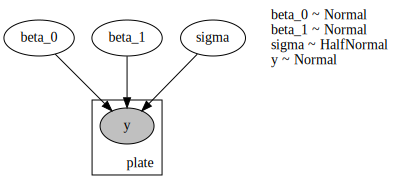

In [25]:
pyro.render_model(
    linear_babies, 
    model_args=(X_, y),
    render_distributions=True
    )

In [26]:
kernel = NUTS(linear_babies, adapt_step_size=True)
mcmc_linear_babies = MCMC(kernel, 500, 300)
mcmc_linear_babies.run(X_, y)

Sample: 100%|██████████| 800/800 [00:11, 70.49it/s, step size=4.43e-01, acc. prob=0.911] 


In [27]:
mcmc_babie_samples = mcmc_linear_babies.get_samples(1000)
predictive = Predictive(linear_babies, mcmc_babie_samples)(X_, None)

az_linear_babies = az.from_pyro(
    posterior=mcmc_linear_babies, posterior_predictive=predictive)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


In [28]:
y_mu = predictive['y'].mean(axis=0)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


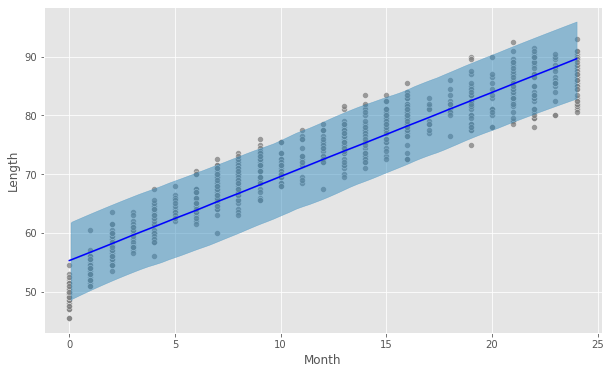

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=babies['Month'], y=babies['Length'], color='grey', alpha=0.75)
sns.lineplot(x=babies['Month'], y=y_mu, color='blue')
az.plot_hdi(x=babies['Month'], y=predictive['y'].numpy())
plt.show()

### Figure 4.3

In [30]:
def sqrt_babies(month, length=None):

    N, P = month.shape
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0, 10.).expand([P]))
    sigma = pyro.sample('sigma', dist.HalfNormal(10.))
    mu = beta_0 + torch.matmul(beta_1, torch.sqrt(month.T))
    
    with pyro.plate('plate', size=N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=length)

In [31]:
kernel = NUTS(sqrt_babies, adapt_step_size=True)
mcmc_sqrt = MCMC(kernel, 500, 300)
mcmc_sqrt.run(X_, y)

Sample: 100%|██████████| 800/800 [00:17, 45.97it/s, step size=2.50e-01, acc. prob=0.949]


In [36]:
mcmc_sqrt_babie_samples = mcmc_sqrt.get_samples(1000)
predictive_sqrt = Predictive(sqrt_babies, mcmc_sqrt_babie_samples)(X_, None)

az_sqrt_babies = az.from_pyro(
    posterior=mcmc_sqrt, posterior_predictive=predictive_sqrt)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


In [38]:
y_mu = predictive_sqrt['y'].mean(axis=0)

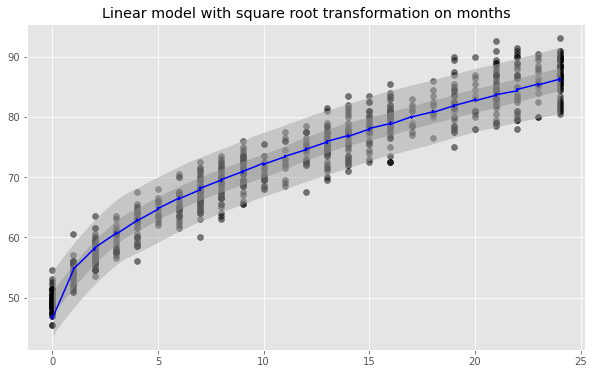

In [69]:
plt.figure(figsize=(10, 6))
plt.scatter(babies['Month'], babies['Length'], c='black', alpha=0.5)
plt.plot(babies['Month'], y_mu, color='blue')
az.plot_hdi(x=babies['Month'], y=az_sqrt_babies['posterior_predictive']['y'], hdi_prob=.50, color='grey')
az.plot_hdi(x=babies['Month'], y=az_sqrt_babies['posterior_predictive']['y'], hdi_prob=.94, color='darkgrey')
plt.title('Linear model with square root transformation on months')
plt.show()

## 4.2 - Varying Uncertainty

## 4.3 - Interaction Effects

In [8]:
tips_df = pd.read_csv(os.path.abspath('.') + '/data/tips.csv')
tips_df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [83]:
total_bill_centered = torch.tensor((tips_df["total_bill"] - tips_df["total_bill"].mean()).values, dtype=torch.float64)
tips = torch.tensor(tips_df["tip"].values, dtype=torch.float64)
smoker = torch.tensor(pd.Categorical(tips_df["smoker"]).codes, dtype=torch.float64)

In [89]:
def interaction_model(bill, smoker, tips=None):
    
    #N, P = 

    beta = pyro.sample('beta', dist.Normal(0., 1.).expand([4]))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))
    mu = beta[0] + beta[1] * bill + beta[2] * smoker + beta[3] * smoker * bill

    with pyro.plate('plate', len(bill)):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=tips)

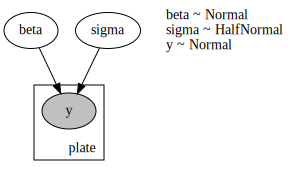

In [90]:
pyro.render_model(
    interaction_model,
    (total_bill_centered, smoker, tips), render_distributions=True)

In [91]:
kernel = NUTS(interaction_model, adapt_step_size=True)
mcmc_interaction = MCMC(kernel, 500, 300)
mcmc_interaction.run(total_bill_centered, smoker, tips)

Sample: 100%|██████████| 800/800 [00:15, 52.72it/s, step size=4.11e-01, acc. prob=0.936]


In [ ]:
mcmc_interaction_samples = mcmc_interaction.get_samples(1000)
interaction_predictive = Predictive(interaction_model, mcmc_interaction_samples)
posterior_predictive = interaction_predictive(total_bill_centered, smoker, None)

az_inference_interaction = az.from_pyro(
    posterior=mcmc_interaction, posterior_predictive=posterior_predictive)

In [117]:
tip_mu = posterior_predictive['y'].mean(axis=0)
tip_std = posterior_predictive['y'].std(axis=0)

predictions = pd.DataFrame({
    'bill': total_bill_centered,
    'smoker': smoker,
    'tip': tips, 
    'tip_mu': tip_mu,
    'tip_std': tip_std,
    'tip_high': tip_mu + tip_std,
    'tip_low': tip_mu - tip_std
})

predictions = predictions.sort_values(by=['bill'])

In [118]:
smoker_df = predictions[predictions['smoker'] == 1]
nonsmoker_df = predictions[predictions['smoker'] == 0]

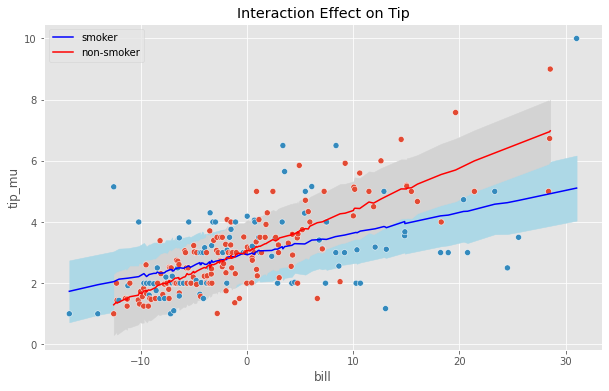

In [149]:
# colors are terrible - TO DO
plt.figure(figsize=(10, 6))
sns.lineplot(x=smoker_df['bill'], y=smoker_df['tip_mu'], color='blue')
plt.fill_between(smoker_df['bill'], smoker_df['tip_low'], smoker_df['tip_high'], color='lightblue')
sns.lineplot(x=nonsmoker_df['bill'], y=nonsmoker_df['tip_mu'], color='red')
plt.fill_between(nonsmoker_df['bill'], nonsmoker_df['tip_low'], nonsmoker_df['tip_high'], color='lightgrey')
sns.scatterplot(x=predictions['bill'], y=predictions['tip'], hue=predictions['smoker'])
plt.legend(['smoker', 'non-smoker'])
plt.title('Interaction Effect on Tip')
plt.show()

## 4.4 - Robust Regression

In [2]:
def generate_sales(*, days, mean, std, label):
    """code taken from the authors / book"""
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    
    return df

Text(0.5, 1.0, 'Empanada Sales')

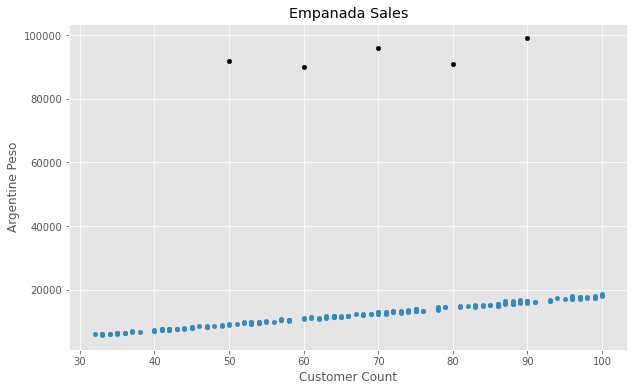

In [7]:
empanadas = generate_sales(days=200, mean=180, std=30, label="Empanada")

empanadas.iloc[0] = [50, 92000, "Empanada"]
empanadas.iloc[1] = [60, 90000, "Empanada"]
empanadas.iloc[2] = [70, 96000, "Empanada"]
empanadas.iloc[3] = [80, 91000, "Empanada"]
empanadas.iloc[4] = [90, 99000, "Empanada"]

empanadas = empanadas.sort_values("customers")

fig, ax = plt.subplots(figsize=(10, 6))
empanadas.sort_values("sales")[:-5].plot(x="customers", y="sales", kind="scatter", ax=ax);
empanadas.sort_values("sales")[-5:].plot(x="customers", y="sales", kind="scatter", c="black", ax=ax);

ax.set_ylabel("Argentine Peso")
ax.set_xlabel("Customer Count")
ax.set_title("Empanada Sales")

In [10]:
customer_count = torch.tensor(empanadas['customers'].values, dtype=torch.float64)
sales = torch.tensor(empanadas['sales'].values, dtype=torch.float64)

In [46]:
def robust_regression(customers, peso=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(50.))
    beta = pyro.sample('beta', dist.Normal(150., 20.))
    v = pyro.sample('dof', dist.HalfNormal(20.))

    mu = pyro.deterministic('mu', beta * customers)

    with pyro.plate('plate', len(customers)):
        sales = pyro.sample('sales', dist.StudentT(loc=mu, scale=sigma, df=v), obs=peso)

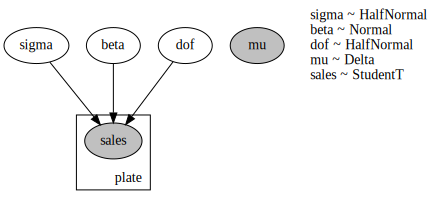

In [47]:
pyro.render_model(
    robust_regression, (customer_count, sales), render_distributions=True)

In [48]:
kernel = NUTS(robust_regression)
mcmc_robust = MCMC(kernel, 500, 300)
mcmc_robust.run(customer_count, sales)

Sample: 100%|██████████| 800/800 [00:09, 85.76it/s, step size=8.01e-01, acc. prob=0.892] 


In [49]:
mcmc_robust.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta    179.61      0.26    179.61    179.14    179.99    381.23      1.00
       dof      1.30      0.16      1.30      1.06      1.57    450.21      1.00
     sigma    152.94     14.04    153.38    129.10    174.57    273.33      1.00

Number of divergences: 0


In [50]:
mcmc_robust_samples = mcmc_robust.get_samples(1000)
robust_predictive = Predictive(robust_regression, mcmc_robust_samples)(customer_count, None)
az_robust_inf = az.from_pyro(posterior=mcmc_robust, posterior_predictive=robust_predictive)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


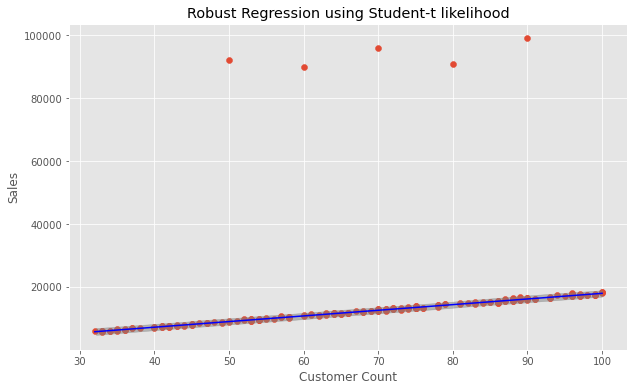

In [57]:
mu = az_robust_inf['posterior_predictive']['mu'].values.reshape(-1, len(customer_count)).mean(axis=0)

plt.figure(figsize=(10, 6))
plt.scatter(customer_count, sales)
plt.plot(customer_count, mu, c='blue')
az.plot_hdi(customer_count, az_robust_inf['posterior_predictive']['sales'], color='grey')
plt.xlabel('Customer Count')
plt.ylabel('Sales')
plt.title('Robust Regression using Student-t likelihood')
plt.show()

## 4.5 - Pooling, Multilevel Models, Mixed Effects

In [60]:
def generate_sales(*, days, mean, std, label):
    """code taken from authors / book"""
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    
    return df

In [61]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")
salad_days = 3
salad_df = generate_sales(days=salad_days, mean=8 ,std=3, label="Salad")

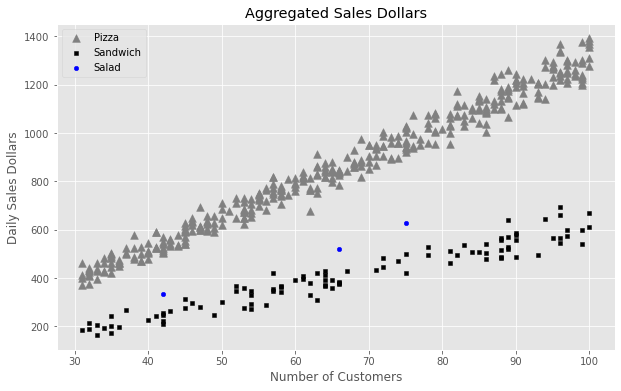

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="grey", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c='black', label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="blue");

ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Aggregated Sales Dollars")
ax.legend()
plt.show()

In [69]:
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)
sales_df["Food_Category"] = pd.Categorical(sales_df["Food_Category"])
sales_df

,customers,sales,Food_Category
0,31,459.895203,Pizza
1,31,401.147736,Pizza
2,31,413.345245,Pizza
3,31,371.909241,Pizza
4,32,433.797089,Pizza
...,...,...,...
463,100,611.736816,Sandwich
464,100,667.152954,Sandwich
465,42,331.625702,Salad
466,66,520.900940,Salad


In [106]:
customers = torch.tensor(sales_df['customers'].values, dtype=torch.float64)
sales = torch.tensor(sales_df['sales'].values, dtype=torch.float64)
food_category = torch.tensor(sales_df['Food_Category'].cat.codes.values, dtype=torch.long)

**Notes:**

- extend shape to 3 because of the 3 food categories
- use `dtype = torch.long` when using a tensor as indices

### Unpooled - MCMC

In [173]:
def unpooled_model(food_cat, customers, sales=None):

    P = 3
    N = len(customers)

    with pyro.plate('sigma_i', len(np.unique(food_cat))):
        sigma = pyro.sample('sigma', dist.HalfNormal(20.).expand([P]))

    with pyro.plate('beta_i', len(np.unique(food_cat))):
        beta = pyro.sample('beta', dist.Normal(10., 10.).expand([P]))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma[food_cat]), obs=sales)

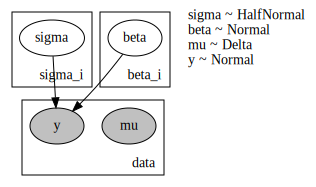

In [174]:
# should be: beta -> mu -> y
pyro.render_model(
    unpooled_model, (food_category, customers, sales),
    render_distributions=True
)

In [132]:
kernel = NUTS(unpooled_model)
mcmc_unpooled = MCMC(kernel, 500, 300)
mcmc_unpooled.run(food_category, customers, sales)

Sample: 100%|██████████| 800/800 [00:10, 75.27it/s, step size=5.90e-01, acc. prob=0.869]


In [137]:
mcmc_unpooled.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     13.02      0.03     13.02     12.98     13.07    719.54      1.00
   beta[1]      8.13      0.21      8.13      7.80      8.52    432.41      1.00
   beta[2]      6.11      0.05      6.11      6.04      6.20    425.55      1.00
  sigma[0]     40.06      1.40     40.03     37.92     42.49    737.77      1.00
  sigma[1]     21.75      8.90     20.44      9.87     35.62    566.12      1.00
  sigma[2]     35.82      2.48     35.74     31.82     39.73    499.05      1.00

Number of divergences: 0


In [133]:
unpooled_posterior_samples = mcmc_unpooled.get_samples(1000)
unpooled_predictive = \
    Predictive(unpooled_model, unpooled_posterior_samples)(food_category, customers, None)

az_unpooled_inf = az.from_pyro(
    posterior=mcmc_unpooled, posterior_predictive=unpooled_predictive)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


In [ ]:
az.plot_trace(az_unpooled_inf, var_names=["beta", "sigma"], compact=False)
plt.tight_layout()

In [ ]:
az.plot_forest(az_unpooled_inf, var_names=['beta'])
plt.show()

In [ ]:
az.plot_forest(az_unpooled_inf, var_names=['sigma'])
plt.show()

### Unpooled - SVI

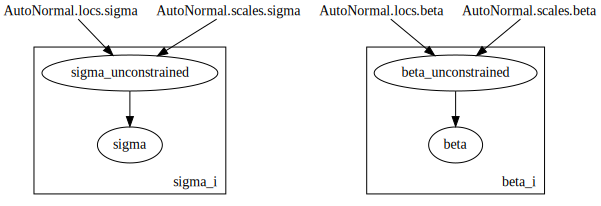

In [251]:
auto_guide = pyro.infer.autoguide.AutoNormal(unpooled_model)
pyro.render_model(
    auto_guide, (food_category, customers, sales), render_params=True)

In [245]:
def unpooled_model(food_cat, customers, sales=None):

    P = 3
    N = len(customers)

    with pyro.plate('sigma_i', len(np.unique(food_cat))):
        sigma = pyro.sample('sigma', dist.HalfNormal(20.).expand([P]))

    with pyro.plate('beta_i', len(np.unique(food_cat))):
        beta = pyro.sample('beta', dist.Normal(10., 10.).expand([P]))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma[food_cat]), obs=sales)

In [246]:
def unpooled_guide(food_cat, customers, sales=None):
    
    P = 3

    with pyro.plate('sigma_i', len(np.unique(food_cat))):
        sigma_scale = pyro.param(
            'sigma_scale', torch.tensor(25.), constraint=constraints.positive)
        sigma = pyro.sample('sigma', dist.HalfNormal(sigma_scale).expand([P]))

    with pyro.plate('beta_i', len(np.unique(food_cat))):
        beta_loc = pyro.param('beta_loc', torch.tensor(10.))
        beta_scale = pyro.param(
            'beta_scale', torch.tensor(10.), constraint=constraints.positive)
        beta = pyro.sample('beta', dist.Normal(beta_loc, beta_scale).expand([P]))

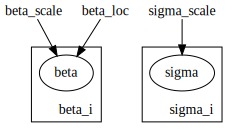

In [247]:
pyro.render_model(
    unpooled_guide, (food_category, customers, sales), render_params=True)

In [263]:
pyro.clear_param_store()

#adam_params = {'lr': 0.001, 'betas': (0.95, 0.99)}
adam_params = {'lr': 0.01}
optim = Adam(adam_params)
svi = SVI(unpooled_model, auto_guide, optim, Trace_ELBO())

elbo_loss = []
for i in range(1000):
    loss = svi.step(food_category, customers, sales)
    elbo_loss.append(loss)

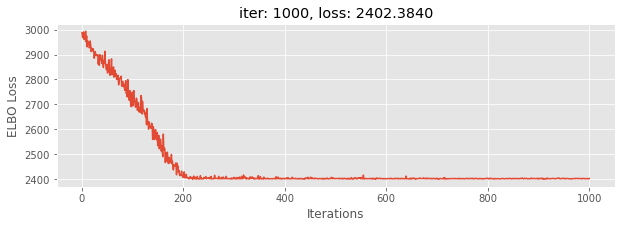

In [264]:
plt.figure(figsize=(10, 3))
plt.plot(np.arange(1, 1001), elbo_loss)
plt.ylabel('ELBO Loss')
plt.xlabel('Iterations')
plt.title(f'iter: 1000, loss: {elbo_loss[-1]:.4f}')
plt.show()

In [265]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.sigma [3.6951559 3.0189881 3.5839252]
AutoNormal.scales.sigma [0.03416998 0.3329743  0.06735786]
AutoNormal.locs.beta [13.004367  8.109899  6.093909]
AutoNormal.scales.beta [0.0344431  0.15599275 0.05363763]


In [266]:
predictive = Predictive(unpooled_model, guide=unpooled_guide, num_samples=1000)
posterior_svi_samples = predictive(food_category, customers, None)

In [267]:
sigma, beta = utils.summary(posterior_svi_samples)['sigma'], \
    utils.summary(posterior_svi_samples)['beta']

In [268]:
beta

,mean,std,5%,25%,50%,75%,95%
0,9.987706,10.070233,-7.152423,3.383125,9.991928,16.883030,26.292870
1,10.232114,9.900408,-5.440229,3.292873,10.133516,16.813399,26.474661
2,10.033931,10.199609,-7.505579,3.439189,9.931513,17.348147,26.290190


In [269]:
sigma

,mean,std,5%,25%,50%,75%,95%
0,19.800735,14.651073,1.423340,8.245490,16.673795,28.963771,48.680047
1,19.457783,14.422979,1.723562,7.817558,16.685498,28.074897,46.949282
2,19.833984,14.945958,1.543425,8.488275,16.085188,29.216510,48.875041


In [ ]:
def unpooled_guide(food_cat, customers, sales=None):
    
    P = 3

    with pyro.plate('sigma_i', len(np.unique(food_cat))):
        sigma_scale = pyro.param(
            'sigma_scale', lambda: torch.tensor(25.).expand(3), constraint=constraints.positive)
        sigma = pyro.sample('sigma', dist.HalfNormal(sigma_scale).expand([P]))

    with pyro.plate('beta_i', len(np.unique(food_cat))):
        beta_loc = pyro.param('beta_loc', lambda: torch.randn(3))
        beta_scale = pyro.param(
            'beta_scale', lambda: torch.tensor(15.).expand(3), constraint=constraints.positive)
        beta = pyro.sample('beta', dist.Normal(beta_loc, beta_scale).expand([P]))